The goal of this project is to use the pretrained RoBERTa transformer as a feature extractor with a costum classification head to determine if text messages are offensive or not.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt

import wandb

import sys
from pathlib import Path

# Add src/ to path (once, so imports work)
sys.path.append(str(Path().resolve().parent / "src"))

from paths import DATA_CLEANED
from paths import DATA_PROCESSED

%load_ext autoreload
%autoreload 2
from helper_functions import train_model, test_model, get_class_distribution, oversample_dataset, undersample_dataset, AttentionPooling

In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Using RoBERTa as a feature extractor with a costum classification head

Found this pretrained model online: cardiffnlp/twitter-roberta-base-sentiment-latest (https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

It is already pretrained on twitter messages. 

Define which pretrained model is used and initilise tokenizer

In [3]:
model_name = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

Classification head

In [4]:
class CustomClassifier(nn.Module):
    def __init__(self, model_name, pooling='cls'):
        super().__init__()
        self.pooling = pooling.lower()
        self.base = AutoModel.from_pretrained(model_name)
        config = AutoConfig.from_pretrained(model_name)
        hidden_size = config.hidden_size  # Dynamically get the model's hidden size

        if pooling == 'attention_pooling'
            # Replace CLS pooling with attention
            self.attention_pool = AttentionPooling(hidden_size)
        
        # Freeze all parameters of the base model
        for param in self.base.parameters():
            param.requires_grad = False

        # Custom classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask, class_weights_tensor = None, labels=None):
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)

        # Pooling strategy: either CLS token or mean pooling over token embeddings
        if self.pooling == 'mean':
            token_embeddings = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1).clamp(min=1e-9)
            pooled = sum_embeddings / sum_mask
        if else self.pooling == 'attention_pooling':
            pooled = self.attention_pool(outputs.last_hidden_state, attention_mask)
        else:
            pooled = outputs.last_hidden_state[:, 0, :]  # CLS token

        logits = self.classifier(pooled)

        # If labels are provided, calculate the loss
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
            loss = loss_fn(logits, labels)
            return logits, loss

        return logits

## Load HASOC dataset for training, validation and testing

In [5]:
# Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, df, tokenizer, label = 'label', max_len=128):
        self.texts = df["text"].tolist()
        self.labels = df[label].tolist()
        self.encodings = tokenizer(self.texts, padding=True, truncation=True, max_length=max_len)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Define experiment scope:

In [6]:
# here we are just using the labels of the first task of the HASOC dataset, which is a binary classification
label = "task_1"

In [7]:
# Load training and test data
clean_df = pd.read_csv(DATA_CLEANED / "hasoc_2019_en_train_cleaned.tsv", sep='\t')
test_df = pd.read_csv(DATA_PROCESSED / "hasoc_2019_en_test.tsv", sep='\t')

# Split clean dataset in training and validation set
train_df, val_df = train_test_split(clean_df, test_size=0.3, random_state=42, stratify=clean_df[label])

# Automatically map string labels to integers
label_list = sorted(train_df[label].unique())
label_map = {label: idx for idx, label in enumerate(label_list)}

train_df[label] = train_df[label].map(label_map)
val_df[label] = val_df[label].map(label_map)
test_df[label] = test_df[label].map(label_map)

# Oversample dataset
# os_train_df = oversample_dataset(train_df, label)
# os_val_df = oversample_dataset(val_df, label)
# os_test_df = oversample_dataset(test_df, label)

# Undersample dataset
us_train_df = undersample_dataset(train_df, label)
us_val_df = undersample_dataset(val_df, label)
us_test_df = undersample_dataset(test_df, label)

# Create PyTorch Datasets and DataLoaders
train_dataset = HateSpeechDataset(us_train_df, tokenizer, label=label)
val_dataset = HateSpeechDataset(us_val_df, tokenizer, label=label)
test_dataset = HateSpeechDataset(us_test_df, tokenizer, label=label)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=32)

print(get_class_distribution(us_train_df, label))

{1: 1583, 0: 1583}


In [8]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(us_train_df[label]),
    y=us_train_df[label]
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

## Training and evaluation of model

In [9]:
# Decide what pooling to use
pooling = "cls"

# Initialize model
model = CustomClassifier(model_name, pooling=pooling).to(device)

# Optimizer only for the classification head
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=2e-4)
epochs = 100

2025-05-13 12:23:46.463051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 12:23:46.479042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747131826.498346   54737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747131826.504173   54737 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747131826.518742   54737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

768


In [10]:
wandb.init(project="roberta-classifier", config={
    "model": model_name,
    "frozen_base": True,
    "pooling": pooling,
    "epochs": epochs,
    "lr": 2e-4,
    "handling_imbalance": "undersampling"
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: natalia-timokhova-v (natalia-timokhova-v-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
train_model(model, train_loader, val_loader, optimizer, device, class_weights_tensor, epochs)


Epoch 1
Training Loss: 0.6919
Train Accuracy: 0.5193
Train F1 (macro): 0.5147

Val Loss: 0.6873
Val Accuracy: 0.5192
Val F1 (macro): 0.3857

New best model saved (F1: 0.3857, Acc: 0.5192)

Epoch 2
Training Loss: 0.6829
Train Accuracy: 0.5872
Train F1 (macro): 0.5863

Val Loss: 0.6782
Val Accuracy: 0.5863
Val F1 (macro): 0.5543

New best model saved (F1: 0.5543, Acc: 0.5863)

Epoch 3
Training Loss: 0.6753
Train Accuracy: 0.5963
Train F1 (macro): 0.5962

Val Loss: 0.6701
Val Accuracy: 0.6114
Val F1 (macro): 0.6013

New best model saved (F1: 0.6013, Acc: 0.6114)

Epoch 4
Training Loss: 0.6671
Train Accuracy: 0.6077
Train F1 (macro): 0.6077

Val Loss: 0.6672
Val Accuracy: 0.6025
Val F1 (macro): 0.5801


Epoch 5
Training Loss: 0.6609
Train Accuracy: 0.6175
Train F1 (macro): 0.6175

Val Loss: 0.6598
Val Accuracy: 0.6069
Val F1 (macro): 0.5976


Epoch 6
Training Loss: 0.6580
Train Accuracy: 0.6222
Train F1 (macro): 0.6222

Val Loss: 0.6543
Val Accuracy: 0.6246
Val F1 (macro): 0.6227

New bes

## Testing of model

Test Loss: 0.5856
Test Accuracy: 0.7378
Test F1 (macro): 0.7358



epoch,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▄▅▆▆▆▇▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇██▇█▇████
train_f1_macro,▁▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇█▇██▇▇▇▇███
train_f1_weighted,▁▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇██▇██▇
train_loss,▅▄▄▂▄▄▃▅▆▅▄▄▄▃▄▄▄▆▅▄█▇▃▃▇▄▆▆▄▄▃▃▅▂▃▄▁▃▄▅


{'f1': 0.7357758031442242, 'accuracy': 0.7378472222222222}

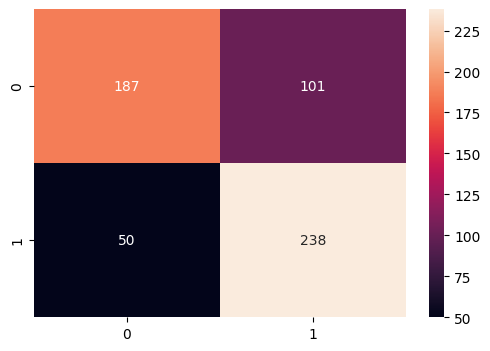

In [12]:
# Load best model
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
# Test model on test set
test_model(model, test_loader, device, class_weights_tensor, phase = "test")